In [1]:
import os 
import cv2
import numpy as np
from PIL import Image
import albumentations as alb 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tqdm import tqdm 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, Conv2DTranspose, Dense, BatchNormalization,
    GlobalAveragePooling2D, MaxPooling2D, LeakyReLU,
    Dropout, Input, Reshape
)

In [2]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [3]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


In [4]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
image_shape = (64, 64, 3)
augmentation = alb.Compose([
        alb.CenterCrop(160, 160),
        alb.Resize(image_shape[0], image_shape[1], always_apply=True),
        alb.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)  
    ])

In [5]:
def data_loader(batch_image_path):
    batch_images = []
    for path in batch_image_path:
        full_path = os.path.join(faces_path, path)
        img = np.array(Image.open(full_path).convert('RGB'))
        img = augmentation(image=img)['image']
        batch_images.append(img)
    batch_images = np.array(batch_images)
    return batch_images

In [6]:
def residual_block(x):
    a = x
    for i in range(3):
        x = Conv2DTranspose(x.shape[-1]*2, strides=2, kernel_size=7, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    a_ = Conv2DTranspose(x.shape[-1], strides=8, kernel_size=3)(a)
    a_ = BatchNormalization()(a_)
    a_ = LeakyReLU()(a_)
    x = tf.math.add(a_, x )
    x = Conv2DTranspose(a.shape[-1], kernel_size=7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

In [7]:
def generator(inp_shape, image_shape):
    inp_ = Input(shape=(inp_shape))
    x = Dense(2*2*2, use_bias=False)(inp_)
    x = Reshape((2, 2, 2))(x)
    x = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    for i in range(1):
        x = residual_block(x)
    x = Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', use_bias=False, activation='tanh')(x)
    model = Model(inp_, x)
    return model

In [8]:
def inception_block(x):
    a = Conv2D(x.shape[-1], kernel_size=1, padding='same', use_bias=False)(x)
    a = LeakyReLU()(a)
    
    b = Conv2D(x.shape[-1], kernel_size=1, padding='same', use_bias=False)(x)
    b = LeakyReLU()(b)
    b = Conv2D(x.shape[-1], kernel_size=3, padding='same', use_bias=False)(b)
    b = LeakyReLU()(b)
    
    c = Conv2D(x.shape[-1], kernel_size=1, padding='same', use_bias=False)(x)
    c = LeakyReLU()(c)
    c = Conv2D(x.shape[-1], kernel_size=5, padding='same', use_bias=False)(c)
    c = LeakyReLU()(c)
    
    d = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    d = Conv2D(x.shape[-1], kernel_size=1, padding='same', use_bias=False)(d)
    d = LeakyReLU()(d)
    
    x = tf.concat([a, b, c, d], axis=-1)
    return x

In [9]:
def discriminator(image_shape):
    inp_ = Input(shape=image_shape)
    x = Conv2D(32, kernel_size=3, padding='same', use_bias=False)(inp_)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    for i in range(2):
        x = inception_block(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
#         x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(100)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inp_, x)
    return model

In [10]:
def gan(generator, discriminator):
    discriminator.trainable = False
    inp_ = Input(shape=(z_dims))
    x = generator(inp_)
    x = discriminator(x)
    model = Model(inp_, x)
    return model

In [11]:
z_dims = 100
image_shape = (64, 64, 3)

In [12]:
discriminator_model = discriminator(image_shape)
discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=2e-4, beta_1=0.5, beta_2=0.999), metrics=['accuracy'])

generator_model = generator(z_dims, image_shape)

gan_model = gan(generator_model, discriminator_model)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3, beta_1=0.5, beta_2=0.999), metrics=['accuracy'])

In [13]:
def image_generation(generator_model):
    z = np.random.normal(0, 1, (7*7, 100))
    images = generator_model.predict(z)
    images = images*0.5 + 0.5
    fig, axis = plt.subplots(7, 7, figsize=(10, 10))
    
    num = 0
    for i in range(7):
        for j in range(7):
            axis[i, j].imshow(images[num, :, :, :])
            num += 1
    plt.show()

In [14]:
def train(batch_size, epochs):
    for epoch in range(epochs):
        steps = len(image_path)//batch_size
        running_loss = 0
        running_acc = 0
        running_gan_loss = 0
        for step in tqdm(range(steps)):
            if (step+1)*batch_size > len(image_path):
                batch_image_path = image_path[step*batch_size :]
            else:
                batch_image_path = image_path[step*batch_size: (step+1)*batch_size]
            batch_images = data_loader(batch_image_path)
            z = np.random.normal(0, 1, (batch_images.shape[0], 100))
            
            real_labels = np.ones((batch_images.shape[0], 1))*0.9
            fake_labels = np.ones((batch_images.shape[0], 1))*0.0
            
            generated_image = generator_model.predict(z)
            
#             discriminator.trainable = True
            
            real_images_loss, accuracy_real = discriminator_model.train_on_batch(batch_images, real_labels)
            fake_images_loss, accuracy_fake = discriminator_model.train_on_batch(generated_image, fake_labels)
            
            loss = (real_images_loss + fake_images_loss)/2
            accuracy = (accuracy_real + accuracy_fake)/2
            running_loss += loss
            running_acc += accuracy
            
            z = np.random.normal(0, 1, (batch_images.shape[0], 100))
            
#             discriminator.trainable = False
            
            gan_loss, gan_accuracy = gan_model.train_on_batch(z, real_labels)
            running_gan_loss += gan_loss
            
        np.random.shuffle(image_path)
            
        print(f'EPOCH {epoch} COMPLETE |  DISCRIMINATOR-LOSS = {running_loss/steps} | DISCRIMINATOR-ACC {running_acc/steps} | GAN-LOSS {running_gan_loss/steps}' )
        image_generation(generator_model)

In [15]:
faces_path = 'img_align_celeba'
image_path = os.listdir(faces_path)

In [16]:
epochs = 3
batch_size = 64

In [17]:
lr_ = [0.1, 0.01, 0.001, 0.0005, 0.0001]
for i in range(len(lr)):
    discriminator_model = discriminator(image_shape)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_[i], beta_1=0.5, beta_2=0.999), metrics=['accuracy'])

    generator_model = generator(z_dims, image_shape)

    gan_model = gan(generator_model, discriminator_model)
    gan_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_[i], beta_1=0.5, beta_2=0.999), metrics=['accuracy'])
    train(batch_size, epochs)

  0%|          | 0/1582 [00:12<?, ?it/s]


ResourceExhaustedError:  OOM when allocating tensor with shape[128,512,64,64] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_1/batch_normalization_2/FusedBatchNormV3 (defined at <ipython-input-14-34c78fabbd17>:22) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_3468]

Function call stack:
train_function


In [58]:
a = np.random.normal(0, 1, (1, 100))

In [59]:
x = generator_model.predict(a)

In [60]:
x = x*0.5 + 0.5

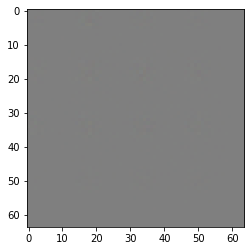

In [61]:
plt.imshow(x[0])

In [ ]:
!killall -9 python3